In [1]:
BASE_DIR = "/tmp/akshett.jindal"

In [2]:
MODEL_IDS = [
    "Salesforce/instructblip-vicuna-13b",
    "HuggingFaceM4/idefics-9b-instruct",
    "llava-hf/llava-1.5-13b-hf",
    # "google/vit-huge-patch14-224-in21k",
]
SUBJECTS = [1, 2, 5, 7]

In [3]:
ROIS = [
    "HCP_MMP1",
    "floc-bodies",
    "floc-faces",
    "floc-places",
    "floc-words",
    "prf-eccrois",
    "prf-visualrois",
]

In [4]:
import os.path
import pandas
import pickle

rows = []

for model_id in MODEL_IDS:

    for subject in SUBJECTS:
        model_name = model_id.replace("/", "_").replace(" ", "_")

        scores_dir = os.path.join(BASE_DIR, "final_scores", model_name, f"subj{subject:02}")

        # trn_scores_filepath = os.path.join(scores_dir, "training.pkl")
        val_scores_filepath = os.path.join(scores_dir, "validation.pkl")

        # with open(trn_scores_filepath, "rb") as f:
        #     trn_scores = pickle.load(f)
        with open(val_scores_filepath, "rb") as f:
            val_scores = pickle.load(f)

        # for hs_name, hs_scores in trn_scores.items():
        #     print(tabulate_scores(hs_name, hs_scores, False))
        #     print(f"MODEL='{model_id}' => {hs_name}, SUBJECT={subject}")
        #     print()

        for hs_name, hs_scores in val_scores.items():
            for roi in ROIS:
                rows.append({
                    "model_id": model_id,
                    "subject": subject,
                    "hidden_state_name": hs_name,
                    "roi": roi,
                    "score": hs_scores[roi],
                })

df_data = {
    key: [r[key] for r in rows]
    for key in rows[0].keys()
}

df = pandas.DataFrame(data=df_data)
df

,model_id,subject,hidden_state_name,roi,score
0,Salesforce/instructblip-vicuna-13b,1,qformer_hidden_states,HCP_MMP1,0.029587
1,Salesforce/instructblip-vicuna-13b,1,qformer_hidden_states,floc-bodies,0.173579
2,Salesforce/instructblip-vicuna-13b,1,qformer_hidden_states,floc-faces,0.066294
3,Salesforce/instructblip-vicuna-13b,1,qformer_hidden_states,floc-places,0.132986
4,Salesforce/instructblip-vicuna-13b,1,qformer_hidden_states,floc-words,0.041660
...,...,...,...,...,...
107,llava-hf/llava-1.5-13b-hf,7,hidden_states,floc-faces,0.113482
108,llava-hf/llava-1.5-13b-hf,7,hidden_states,floc-places,0.148197
109,llava-hf/llava-1.5-13b-hf,7,hidden_states,floc-words,0.057720
110,llava-hf/llava-1.5-13b-hf,7,hidden_states,prf-eccrois,0.021519


In [5]:
df[(df["model_id"] == "Salesforce/instructblip-vicuna-13b") & (df["roi"] == "floc-places") & (df["subject"] == 1) & (df["hidden_state_name"] == "qformer_hidden_states")]["score"].values[0]

0.13298571

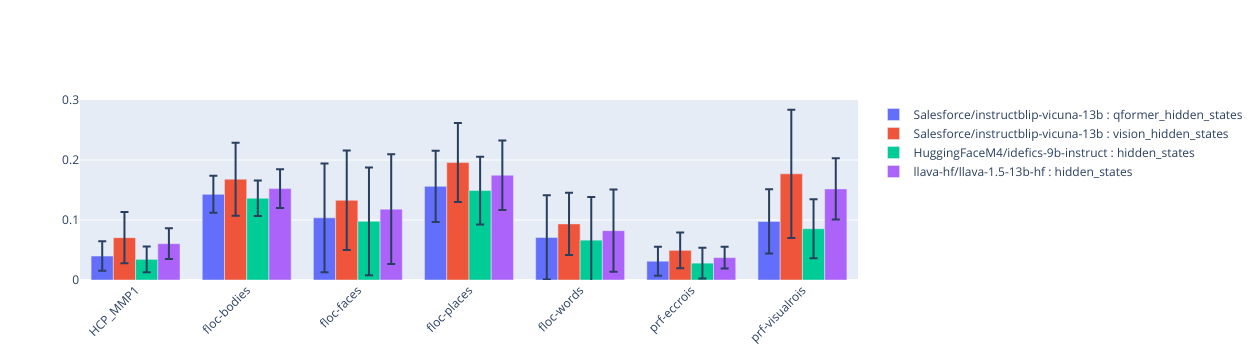

In [9]:
import plotly.graph_objects as go

fig = go.Figure()

for model_id in MODEL_IDS:
    hs_types = df[df["model_id"] == model_id]["hidden_state_name"].unique()
    roi_scores = {roi: 0 for roi in ROIS}
    roi_maxes = {roi: -1 for roi in ROIS}
    roi_mins = {roi: 1 for roi in ROIS}
    for hs_type in hs_types:
        for subject in SUBJECTS:
            for roi in ROIS:
                subject_roi_score = df[
                    (df["model_id"] == model_id) &
                    (df["roi"] == roi) &
                    (df["subject"] == subject) &
                    (df["hidden_state_name"] == hs_type)
                ]["score"].values[0]

                roi_scores[roi] += subject_roi_score
                roi_maxes[roi] = max(subject_roi_score, roi_maxes[roi])
                roi_mins[roi] = min(subject_roi_score, roi_mins[roi])

        for roi, score in roi_scores.items():
            roi_scores[roi] = score / 4

        error_y = {roi: 1 for roi in ROIS}
        for roi in ROIS:
            error_y[roi] = max(
                abs(roi_scores[roi] - roi_maxes[roi]),
                abs(roi_scores[roi] - roi_mins[roi]),
            )

        fig.add_trace(go.Bar(
            x=ROIS,
            y=[roi_scores[roi] for roi in ROIS],
            name=f"{model_id} : {hs_type}",
            error_y=dict(type="data", array=[error_y[roi] for roi in ROIS])
        ))

fig.update_layout(barmode="group", xaxis_tickangle=-45, yaxis_range=[0, 0.3])
fig.show()